# This notebook is whrer I have trained teh Regression model to learn how the customers are reacting to the price ,the inventory changes and price changes

In [1]:
#imprting essentials
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

In [18]:
#GET  IN THE DATA
df = pd.read_csv("A:\\study\\projects\\EtE_ETL_Dynamic_pricing__ML\\data\\transactions.csv")

In [19]:
df.head(25)

,timestamp,product_name,price_offered,inventory_level,budget_multiplier,purchased
0,2026-01-14 11:31:35,Milk,1.50,100,1.17,1
1,2026-01-14 11:31:35,Eggs,1.00,100,0.68,0
2,2026-01-14 11:31:35,Milk,1.50,99,1.31,1
3,2026-01-14 11:31:35,Milk,2.21,98,1.16,0
4,2026-01-14 11:31:35,Bread,1.10,100,1.12,1
5,2026-01-14 11:31:36,Meat,8.58,100,0.85,0
6,2026-01-14 11:31:36,Milk,2.21,98,1.12,0
7,2026-01-14 11:31:36,Cheese,8.02,100,1.25,1
8,2026-01-14 11:31:36,Cheese,8.02,99,0.92,0
9,2026-01-14 11:31:36,Meat,7.60,100,1.05,1


In [20]:
df.describe()

,price_offered,inventory_level,budget_multiplier,purchased
count,2630.000000,2630.000000,2630.000000,2630.000000
mean,4.182414,30.823954,1.000703,0.190114
std,3.489989,33.319616,0.198701,0.392466
min,0.800000,0.000000,0.280000,0.000000
25%,1.260000,0.000000,0.870000,0.000000
50%,1.700000,20.000000,1.010000,0.000000
75%,7.625000,58.000000,1.140000,0.000000
max,11.500000,100.000000,1.580000,1.000000


# Remove inv level 0
I am trying to remove the rows where the inventory was 0 because it is creating a bias in the model 

In [21]:
df = df[df['inventory_level'] > 0]


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1567 entries, 0 to 1808
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          1567 non-null   object 
 1   product_name       1567 non-null   object 
 2   price_offered      1567 non-null   float64
 3   inventory_level    1567 non-null   int64  
 4   budget_multiplier  1567 non-null   float64
 5   purchased          1567 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 85.7+ KB


In [23]:
df = df[df['purchased'].isin([0, 1])]

# We gonna eprform some extensive EDA now 

In [24]:
%matplotlib inline

In [25]:
balance = df['purchased'].value_counts(normalize=True)

In [29]:
print("Distribution of decisions")
print(balance)

Distribution of decisions
purchased
0    0.680919
1    0.319081
Name: proportion, dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_27596\3935358452.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='purchased', data=df, palette='pastel')


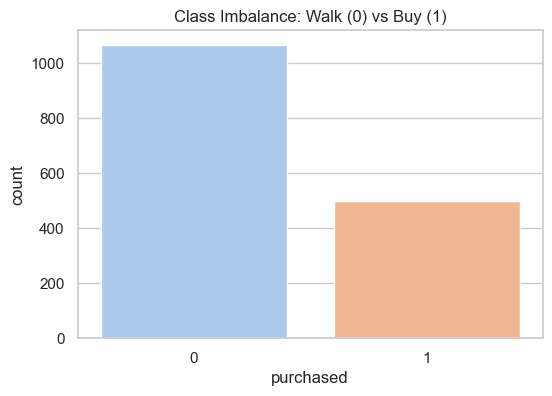

In [31]:
plt.figure(figsize=(6, 4))
sns.countplot(x='purchased', data=df, palette='pastel')
plt.title("Class Imbalance: Walk (0) vs Buy (1)")
plt.show()

  Product  Conversion_Rate
0   Bread         0.326797
1  Cheese         0.315457
2    Eggs         0.297619
3    Meat         0.326797
4    Milk         0.331126


C:\Users\HP\AppData\Local\Temp\ipykernel_27596\1416602627.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Product', y='Conversion_Rate', data=product_stats, palette='viridis')


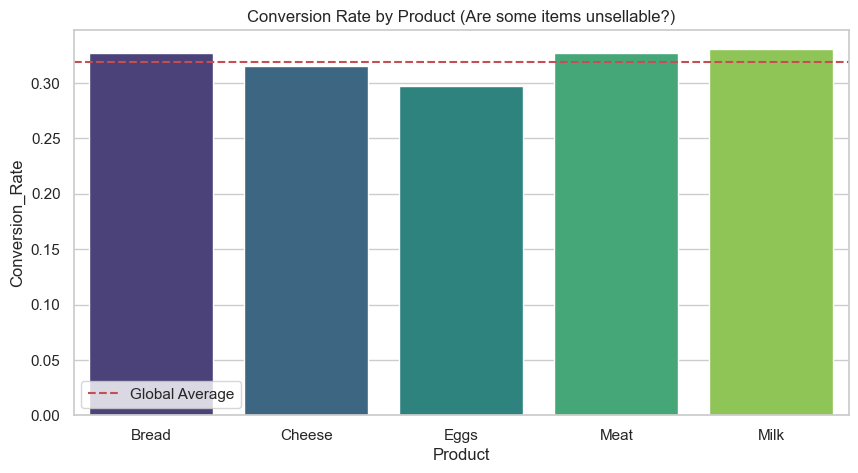

In [33]:
# Calculate conversion rate per product
product_stats = df.groupby('product_name')['purchased'].mean().reset_index()
product_stats.columns = ['Product', 'Conversion_Rate']

print(product_stats)

plt.figure(figsize=(10, 5))
sns.barplot(x='Product', y='Conversion_Rate', data=product_stats, palette='viridis')
plt.axhline(y=df['purchased'].mean(), color='r', linestyle='--', label='Global Average')
plt.title("Conversion Rate by Product (Are some items unsellable?)")
plt.legend()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_27596\2037563885.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_bin', y='purchased', data=df, palette="RdYlGn_r")


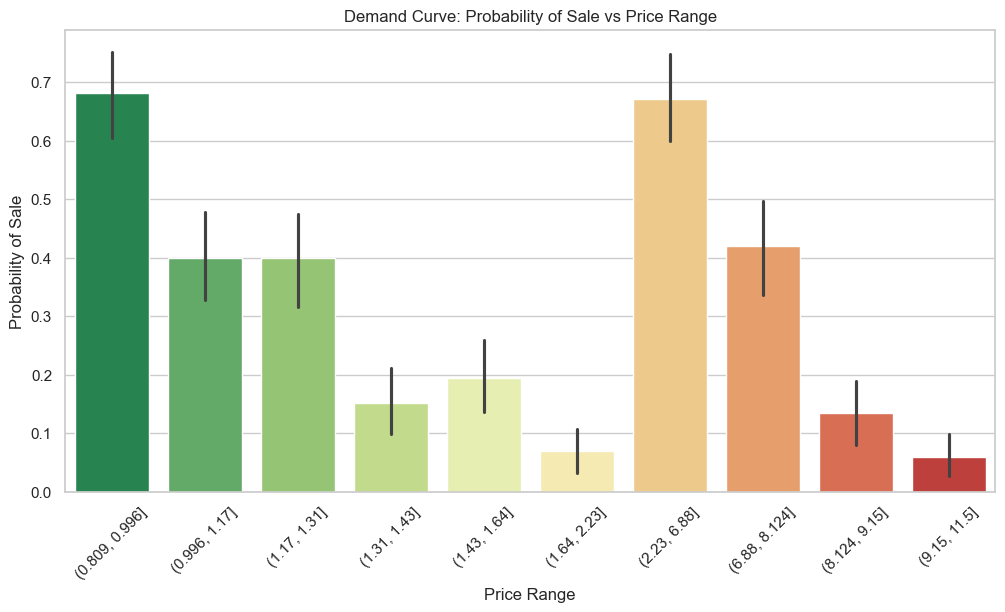

In [34]:
# Create Price Bins to visualize trends
# We divide prices into 10 buckets
df['price_bin'] = pd.qcut(df['price_offered'], q=10)

plt.figure(figsize=(12, 6))
sns.barplot(x='price_bin', y='purchased', data=df, palette="RdYlGn_r")
plt.xticks(rotation=45)
plt.title("Demand Curve: Probability of Sale vs Price Range")
plt.ylabel("Probability of Sale")
plt.xlabel("Price Range")
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_27596\2218140957.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='purchased', y='budget_multiplier', data=df, palette='coolwarm')


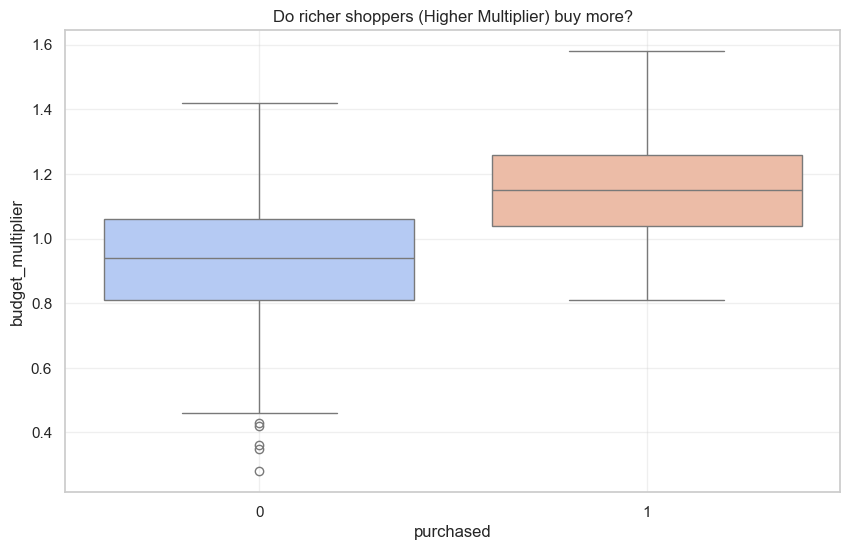

In [35]:
plt.figure(figsize=(10, 6))
# Boxplot shows the distribution of budget multipliers for Buys vs Walks
sns.boxplot(x='purchased', y='budget_multiplier', data=df, palette='coolwarm')
plt.title("Do richer shoppers (Higher Multiplier) buy more?")
plt.grid(True, alpha=0.3)
plt.show()

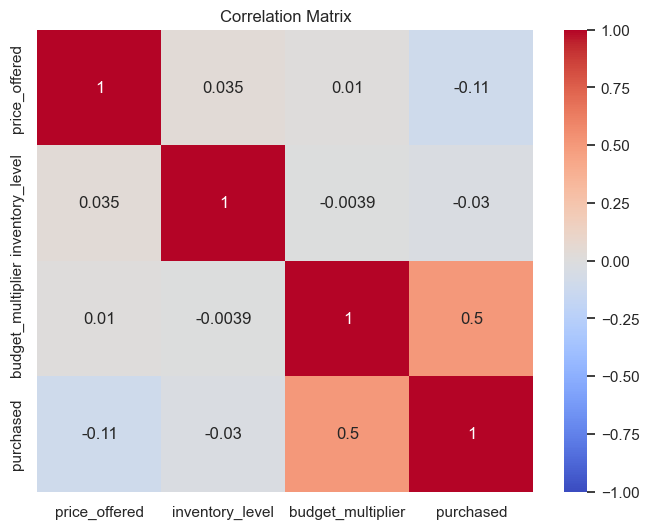

In [36]:
# Select only numeric columns
cols = ['price_offered', 'inventory_level', 'budget_multiplier', 'purchased']
corr = df[cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# applyinmg encoding because right now based on the EDA the model is not able to distinguish between items, it only sees the price and inventory then it makes a prediction.
we will fix it with hot encoding 

In [37]:
df_encoded = pd.get_dummies(df, columns=['product_name'], drop_first=False)

In [39]:
df_encoded.head()

,timestamp,price_offered,inventory_level,budget_multiplier,purchased,price_bin,product_name_Bread,product_name_Cheese,product_name_Eggs,product_name_Meat,product_name_Milk
0,2026-01-14 11:31:35,1.50,100,1.17,1,"(1.43, 1.64]",False,False,False,False,True
1,2026-01-14 11:31:35,1.00,100,0.68,0,"(0.996, 1.17]",False,False,True,False,False
2,2026-01-14 11:31:35,1.50,99,1.31,1,"(1.43, 1.64]",False,False,False,False,True
3,2026-01-14 11:31:35,2.21,98,1.16,0,"(1.64, 2.23]",False,False,False,False,True
4,2026-01-14 11:31:35,1.10,100,1.12,1,"(0.996, 1.17]",True,False,False,False,False


# Implementing Features and deciding whats the target value

In [38]:
feature_cols = ['price_offered', 'inventory_level'] + [c for c in df_encoded.columns if 'product_name_' in c]
target = 'purchased'

In [40]:
X = df_encoded[feature_cols]
y = df_encoded[target].astype(int)

In [53]:
joblib.dump(feature_cols, "models/model_features.pkl")

['models/model_features.pkl']

# Splitting the data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
df.head(10)

,timestamp,product_name,price_offered,inventory_level,budget_multiplier,purchased,price_bin
0,2026-01-14 11:31:35,Milk,1.50,100,1.17,1,"(1.43, 1.64]"
1,2026-01-14 11:31:35,Eggs,1.00,100,0.68,0,"(0.996, 1.17]"
2,2026-01-14 11:31:35,Milk,1.50,99,1.31,1,"(1.43, 1.64]"
3,2026-01-14 11:31:35,Milk,2.21,98,1.16,0,"(1.64, 2.23]"
4,2026-01-14 11:31:35,Bread,1.10,100,1.12,1,"(0.996, 1.17]"
5,2026-01-14 11:31:36,Meat,8.58,100,0.85,0,"(8.124, 9.15]"
6,2026-01-14 11:31:36,Milk,2.21,98,1.12,0,"(1.64, 2.23]"
7,2026-01-14 11:31:36,Cheese,8.02,100,1.25,1,"(6.88, 8.124]"
8,2026-01-14 11:31:36,Cheese,8.02,99,0.92,0,"(6.88, 8.124]"
9,2026-01-14 11:31:36,Meat,7.60,100,1.05,1,"(6.88, 8.124]"


In [44]:
df_encoded.head(10)

,timestamp,price_offered,inventory_level,budget_multiplier,purchased,price_bin,product_name_Bread,product_name_Cheese,product_name_Eggs,product_name_Meat,product_name_Milk
0,2026-01-14 11:31:35,1.50,100,1.17,1,"(1.43, 1.64]",False,False,False,False,True
1,2026-01-14 11:31:35,1.00,100,0.68,0,"(0.996, 1.17]",False,False,True,False,False
2,2026-01-14 11:31:35,1.50,99,1.31,1,"(1.43, 1.64]",False,False,False,False,True
3,2026-01-14 11:31:35,2.21,98,1.16,0,"(1.64, 2.23]",False,False,False,False,True
4,2026-01-14 11:31:35,1.10,100,1.12,1,"(0.996, 1.17]",True,False,False,False,False
5,2026-01-14 11:31:36,8.58,100,0.85,0,"(8.124, 9.15]",False,False,False,True,False
6,2026-01-14 11:31:36,2.21,98,1.12,0,"(1.64, 2.23]",False,False,False,False,True
7,2026-01-14 11:31:36,8.02,100,1.25,1,"(6.88, 8.124]",False,True,False,False,False
8,2026-01-14 11:31:36,8.02,99,0.92,0,"(6.88, 8.124]",False,True,False,False,False
9,2026-01-14 11:31:36,7.60,100,1.05,1,"(6.88, 8.124]",False,False,False,True,False


# Training 

In [46]:
model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,        
    random_state=42,
    class_weight="balanced" 
)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [48]:
pred = model.predict(X_test)

# Accuracy and Eval

In [49]:
accuracy = accuracy_score(y_test, pred)

In [50]:
print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.77


In [51]:
print("Classification Report:")
print(classification_report(y_test, pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       213
           1       0.64      0.68      0.66       101

    accuracy                           0.77       314
   macro avg       0.74      0.75      0.75       314
weighted avg       0.78      0.77      0.78       314



# exporting the model

In [52]:


joblib.dump(model, "models/predictor4.pkl")

['models/predictor4.pkl']